In [116]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

## Load data

In [117]:
load_data = pd.read_csv("./Data/Load_hourly_2050.csv")
load_data['date'] = load_data.apply(lambda x:pd.to_datetime(x['*Hour']-1, origin='2050-01-01',unit='h'),axis=1)
load_data

,*Hour,Load,date
0,1,26927.58882,2050-01-01 00:00:00
1,2,26008.34278,2050-01-01 01:00:00
2,3,25292.68962,2050-01-01 02:00:00
3,4,24895.77208,2050-01-01 03:00:00
4,5,24933.29478,2050-01-01 04:00:00
...,...,...,...
8755,8756,31840.06796,2050-12-31 19:00:00
8756,8757,30699.46724,2050-12-31 20:00:00
8757,8758,29651.53631,2050-12-31 21:00:00
8758,8759,28576.43091,2050-12-31 22:00:00


### define seasons

In [118]:
seasons = ['Winter', 'Spring', 'Summer', 'Fall']
def define_season(date):
    
    if ((date >= pd.Timestamp('2050-03-01')) and (date < pd.Timestamp('2050-06-01'))):
        return 'Spring'
    elif ((date >= pd.Timestamp('2050-06-01')) and (date < pd.Timestamp('2050-09-01'))):
        return 'Summer'
    elif ((date >= pd.Timestamp('2050-09-01')) and (date < pd.Timestamp('2050-12-01'))):
        return 'Fall'
    elif ((date < pd.Timestamp('2050-03-01')) or (date >=pd.Timestamp('2050-12-01'))): 
        return 'Winter'

load_data['Season'] = load_data['date'].apply(define_season)
load_data[load_data.Season == 'Spring']

,*Hour,Load,date,Season
1416,1417,25404.15077,2050-03-01 00:00:00,Spring
1417,1418,24560.06866,2050-03-01 01:00:00,Spring
1418,1419,24135.54237,2050-03-01 02:00:00,Spring
1419,1420,23865.03363,2050-03-01 03:00:00,Spring
1420,1421,24152.63950,2050-03-01 04:00:00,Spring
...,...,...,...,...
3619,3620,33572.39351,2050-05-31 19:00:00,Spring
3620,3621,34039.41975,2050-05-31 20:00:00,Spring
3621,3622,33187.42436,2050-05-31 21:00:00,Spring
3622,3623,31106.16149,2050-05-31 22:00:00,Spring


## Nuclear, Hydro and other renewables

In [119]:
nuclear_gen = pd.read_csv('./Data/Nucl_hourly_2019.csv')
hydro_gen = pd.read_csv('./Data/lahy_hourly_2019.csv')
otre_gen = pd.read_csv('./Data/otre_hourly_2019.csv')
load_data = load_data.merge(right=otre_gen, on='*Hour')
load_data = load_data.merge(right=hydro_gen, on='*Hour')
load_data = load_data.merge(right=nuclear_gen, on='*Hour')

load_data['month'] = load_data['date'].dt.month
load_data['plottime'] = load_data.apply(lambda x:x['date'] if x['month'] !=12 else x['date']-pd.Timedelta(days=365),axis=1)
load_data = load_data.sort_values(by='plottime').reset_index(drop=True)
load_data

,*Hour,Load,date,Season,OtherRenewables,LargeHydro,Nuclear,month,plottime
0,8017,26271.43742,2050-12-01 00:00:00,Winter,1496.501788,1486.397559,1133.150829,12,2049-12-01 00:00:00
1,8018,25439.31354,2050-12-01 01:00:00,Winter,1502.798287,1266.426462,1133.624165,12,2049-12-01 01:00:00
2,8019,24872.22075,2050-12-01 02:00:00,Winter,1502.147954,1045.435418,1133.693944,12,2049-12-01 02:00:00
3,8020,24509.65717,2050-12-01 03:00:00,Winter,1505.046396,857.073098,1133.380390,12,2049-12-01 03:00:00
4,8021,24387.42823,2050-12-01 04:00:00,Winter,1504.605409,923.568473,1133.602907,12,2049-12-01 04:00:00
...,...,...,...,...,...,...,...,...,...
8755,8012,32764.55344,2050-11-30 19:00:00,Fall,1606.670979,2787.083745,1131.686667,11,2050-11-30 19:00:00
8756,8013,32034.99661,2050-11-30 20:00:00,Fall,1595.594622,2391.385409,1132.218334,11,2050-11-30 20:00:00
8757,8014,31014.37051,2050-11-30 21:00:00,Fall,1576.381292,2231.285197,1132.602505,11,2050-11-30 21:00:00
8758,8015,29333.94398,2050-11-30 22:00:00,Fall,1541.431162,2035.587475,1132.806670,11,2050-11-30 22:00:00


## Define worst and random case scenario for each outage duration

In [120]:
scenario_dir = './resilience_scenarios/'
os.makedirs(scenario_dir, exist_ok=True)
from random import randint
durations = [6,12,24,72]

save_data = {}

for duration in durations:
    lp = load_data.copy()
    lr = load_data.copy()
    duration_dir_peak = os.path.join(scenario_dir,f'seasonpeak_outage_{duration}h/')
    duration_dir_random = os.path.join(scenario_dir,f'seasonrandom_outage_{duration}h/')
    os.makedirs(duration_dir_peak, exist_ok=True)
    os.makedirs(duration_dir_random, exist_ok=True)
    for season in seasons: 
        time_delta = pd.Timedelta(duration/2, unit='h')
        oneh = pd.Timedelta(1, unit='h')

        # Peak outage
        peak_hour_id = load_data[load_data.Season == season]['Load'].idxmax()
        peak_hour = load_data.loc[peak_hour_id,'date']
        print(f"Peak hour for season {season} is {peak_hour}")
        lp.loc[ (lp.date>=peak_hour-time_delta+oneh) & (lp.date<=peak_hour+time_delta), 'OtherRenewables'] = 0
        lp.loc[ (lp.date>=peak_hour-time_delta+oneh) & (lp.date<=peak_hour+time_delta), 'LargeHydro'] = 0
        lp.loc[ (lp.date>=peak_hour-time_delta+oneh) & (lp.date<=peak_hour+time_delta), 'Nuclear'] = 0
        

        # Random outage
        print(load_data[load_data.Season == season].index.min())
        print(load_data[load_data.Season == season].index.max())
        random_id = randint(load_data[load_data.Season == season].index.min(), load_data[load_data.Season == season].index.max())
        print(random_id)
        random_hour = load_data.loc[random_id,'date']
        print(random_hour)
        #print(f"Random hour for outage during {season} season is {random_hour}")
        lr.loc[ (lr.date>=random_hour-time_delta+oneh) & (lr.date<=random_hour+time_delta), 'OtherRenewables'] = 0
        lr.loc[ (lr.date>=random_hour-time_delta+oneh) & (lr.date<=random_hour+time_delta), 'LargeHydro'] = 0
        lr.loc[ (lr.date>=random_hour-time_delta+oneh) & (lr.date<=random_hour+time_delta), 'Nuclear'] = 0
    lp.to_csv(os.path.join(duration_dir_peak,f'load_gen_{duration}h.csv'))
    lr.to_csv(os.path.join(duration_dir_random,f'load_gen_{duration}h.csv'))
    save_data[f'seasonpeak_outage_{duration}h'] = lp
    save_data[f'seasonrandom_outage_{duration}h'] = lr

    


    

Peak hour for season Winter is 2050-12-16 18:00:00
0
2159
1285
2050-01-23 13:00:00
Peak hour for season Spring is 2050-04-24 19:00:00
2160
4367
3078
2050-04-08 06:00:00
Peak hour for season Summer is 2050-08-15 17:00:00
4368
6575
5123
2050-07-02 11:00:00
Peak hour for season Fall is 2050-09-03 17:00:00
6576
8759
7969
2050-10-29 01:00:00
Peak hour for season Winter is 2050-12-16 18:00:00
0
2159
803
2050-01-03 11:00:00
Peak hour for season Spring is 2050-04-24 19:00:00
2160
4367
2221
2050-03-03 13:00:00
Peak hour for season Summer is 2050-08-15 17:00:00
4368
6575
5452
2050-07-16 04:00:00
Peak hour for season Fall is 2050-09-03 17:00:00
6576
8759
8191
2050-11-07 07:00:00
Peak hour for season Winter is 2050-12-16 18:00:00
0
2159
938
2050-01-09 02:00:00
Peak hour for season Spring is 2050-04-24 19:00:00
2160
4367
2840
2050-03-29 08:00:00
Peak hour for season Summer is 2050-08-15 17:00:00
4368
6575
5162
2050-07-04 02:00:00
Peak hour for season Fall is 2050-09-03 17:00:00
6576
8759
7976
2050-

## Graphs

Iterate through all scenarios and durations and create and save plots in respective folders

In [121]:
import matplotlib.dates as mdates

In [122]:
def plot_scenario(scenario_name, df):
    save_dir = os.path.join(scenario_dir,scenario_name+'/')
    
    pltdata2 = df.set_index('plottime').sort_index()
    pltdata2['OtherRenewables'] /=1e3
    pltdata2['LargeHydro'] /=1e3
    pltdata2['Nuclear'] /=1e3
    pltdata2['Load'] /=1e3

    fig, ax = plt.subplots(2,4, figsize=(16,8))
    for i, season in enumerate(seasons):
        df = pltdata2[pltdata2.Season == season]
        ax[0,i].plot(df.index, df['Load'], label='Load', color='red', alpha=0.7)
        ax[0,i].set_title(season)
        ax[0,i].set_ylim(20,55)
        ax[1,i].plot(df.index, df['OtherRenewables'], label='Other Renewables', color='green', alpha=0.7)
        ax[1,i].plot(df.index, df['LargeHydro'], label='LargeHydro', color='skyblue', alpha=0.7)
        ax[1,i].plot(df.index, df['Nuclear'], label='Nuclear', color='darkviolet', alpha=0.7)
        ax[1,i].set_ylim(-0.10,6.1)
        ax[0,i].xaxis.set(major_locator=mdates.MonthLocator(), major_formatter=mdates.DateFormatter('%m-%d'))
        ax[1,i].xaxis.set(major_locator=mdates.MonthLocator(), major_formatter=mdates.DateFormatter('%m-%d'))
        ax[0,0].set_ylabel('Load [GW]')
        ax[1,0].set_ylabel('Generation [GW]')
        
    handles, labels = ax[1,0].get_legend_handles_labels()
    h, l = ax[0,0].get_legend_handles_labels()
    fig.legend(handles+h, labels+l, loc='upper center')
    fig.savefig(os.path.join(save_dir, scenario_name+'.png'))


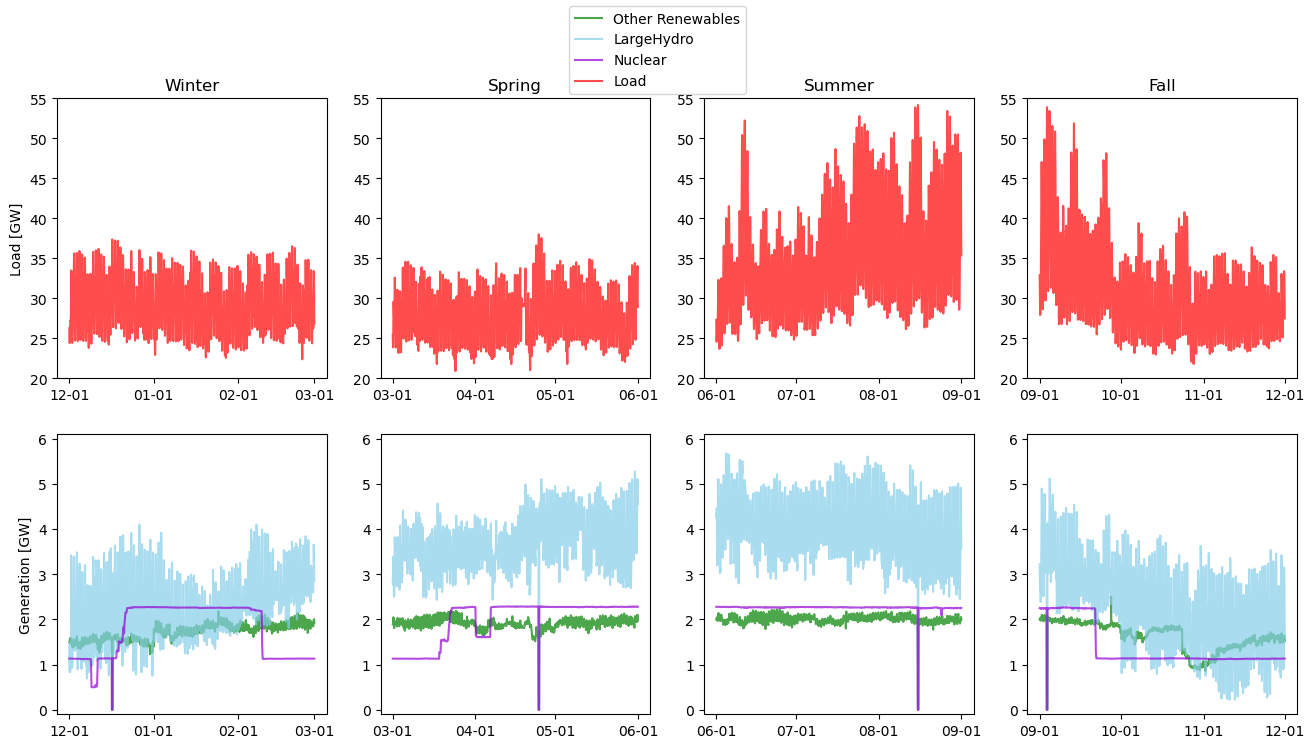

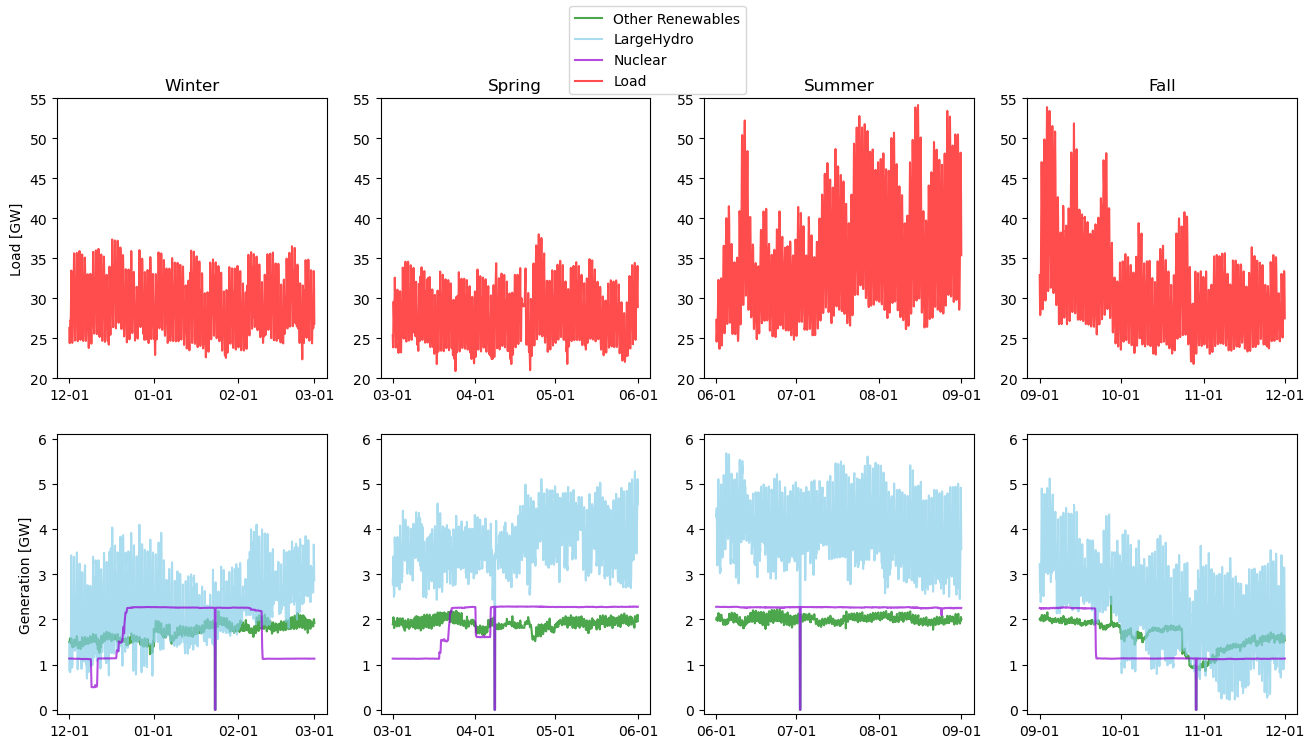

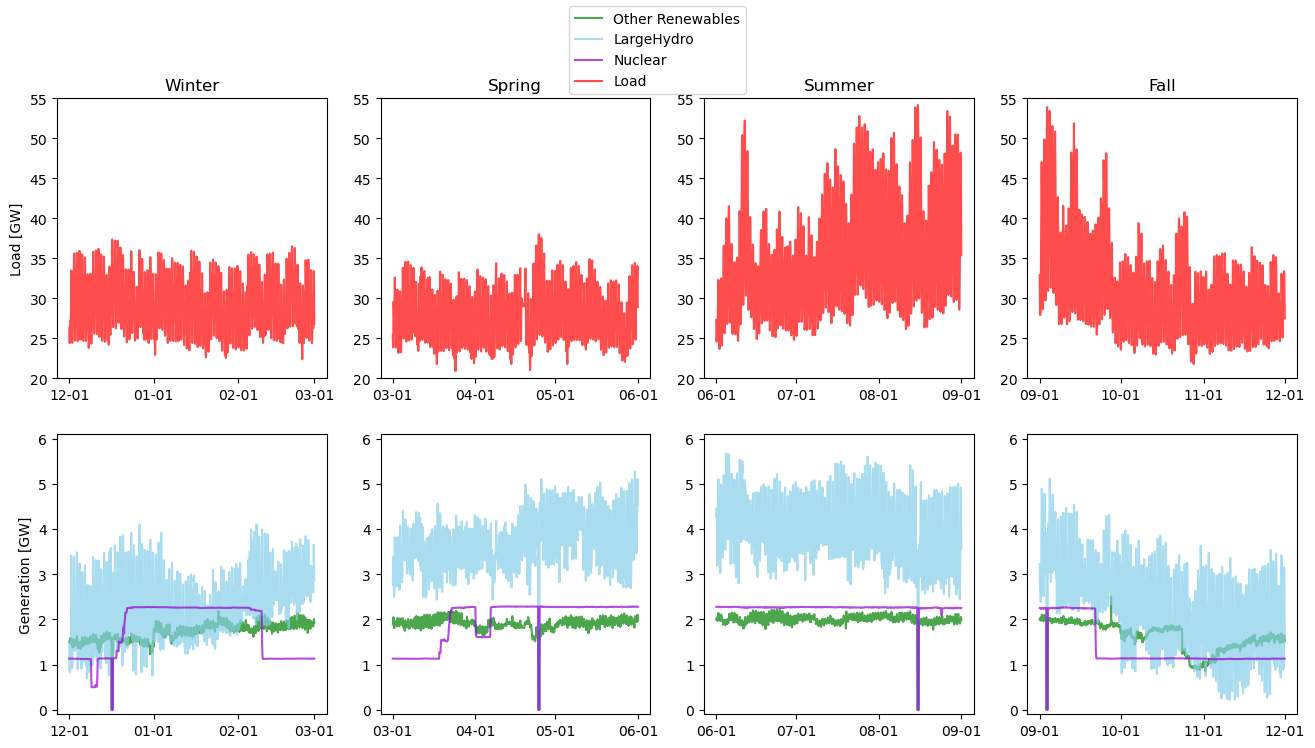

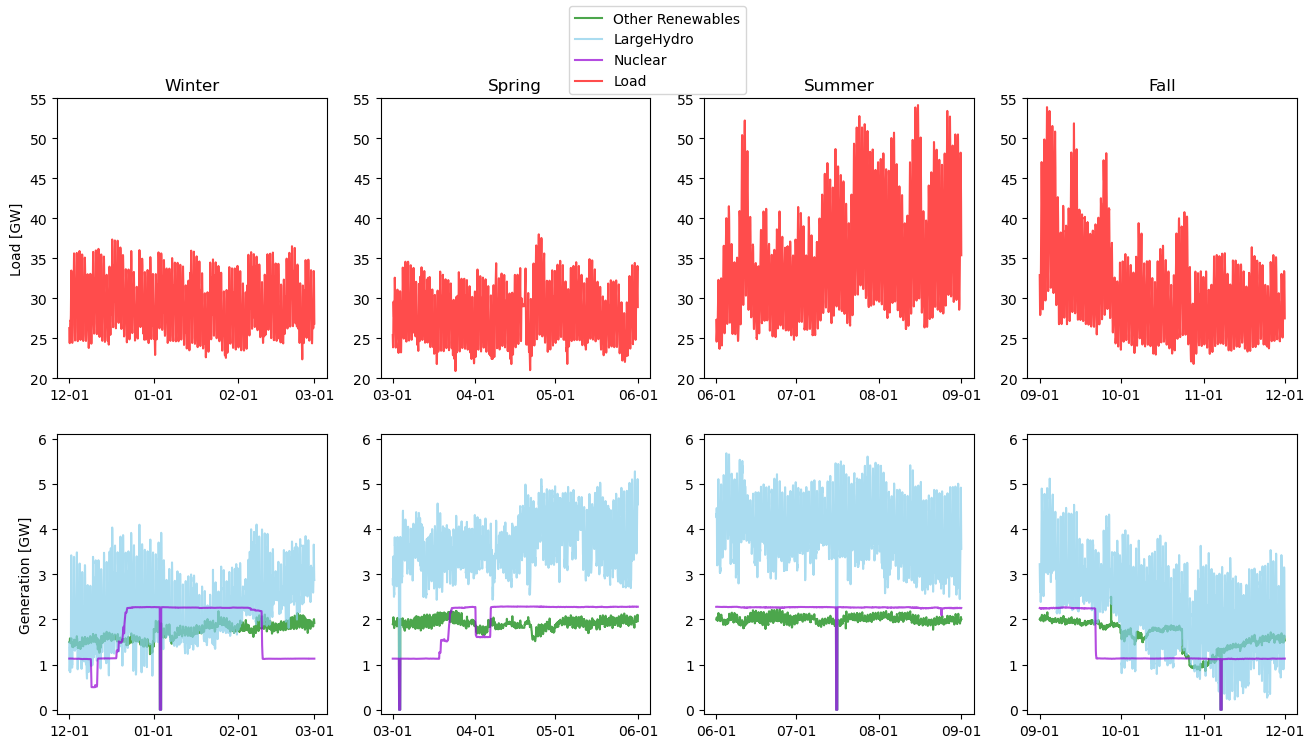

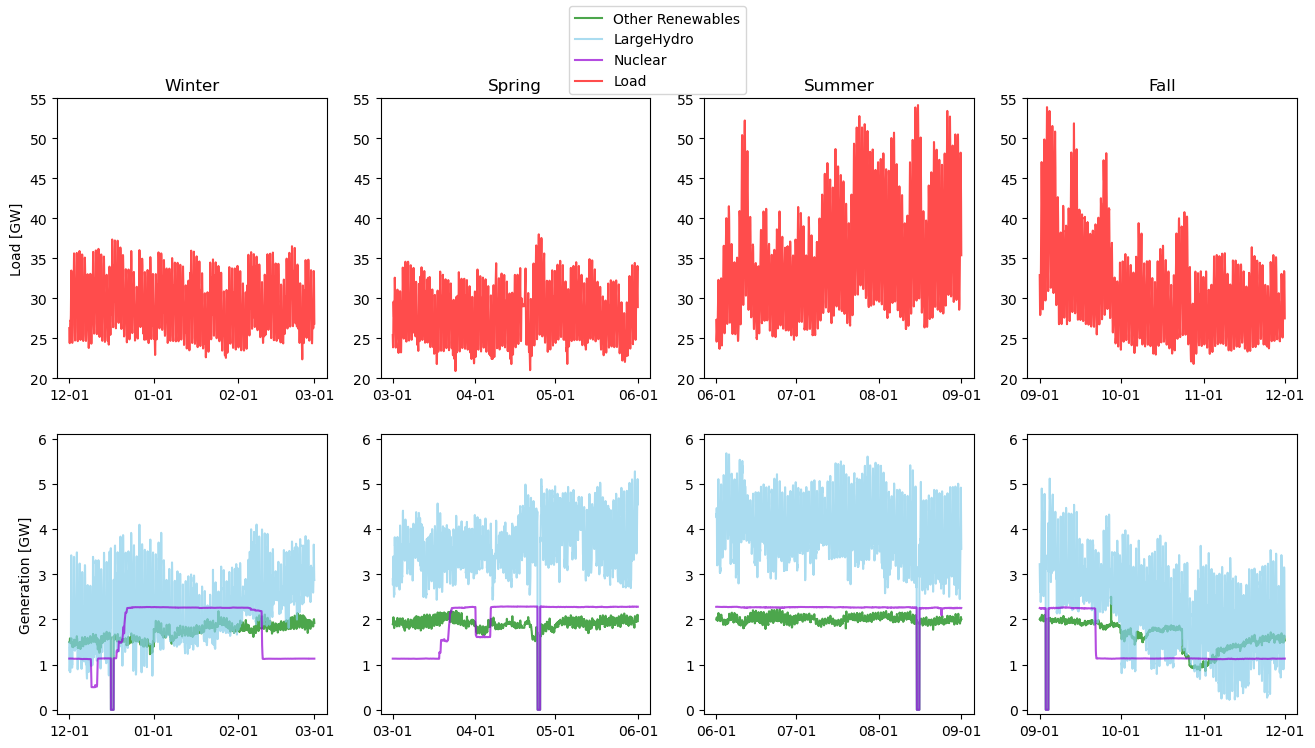

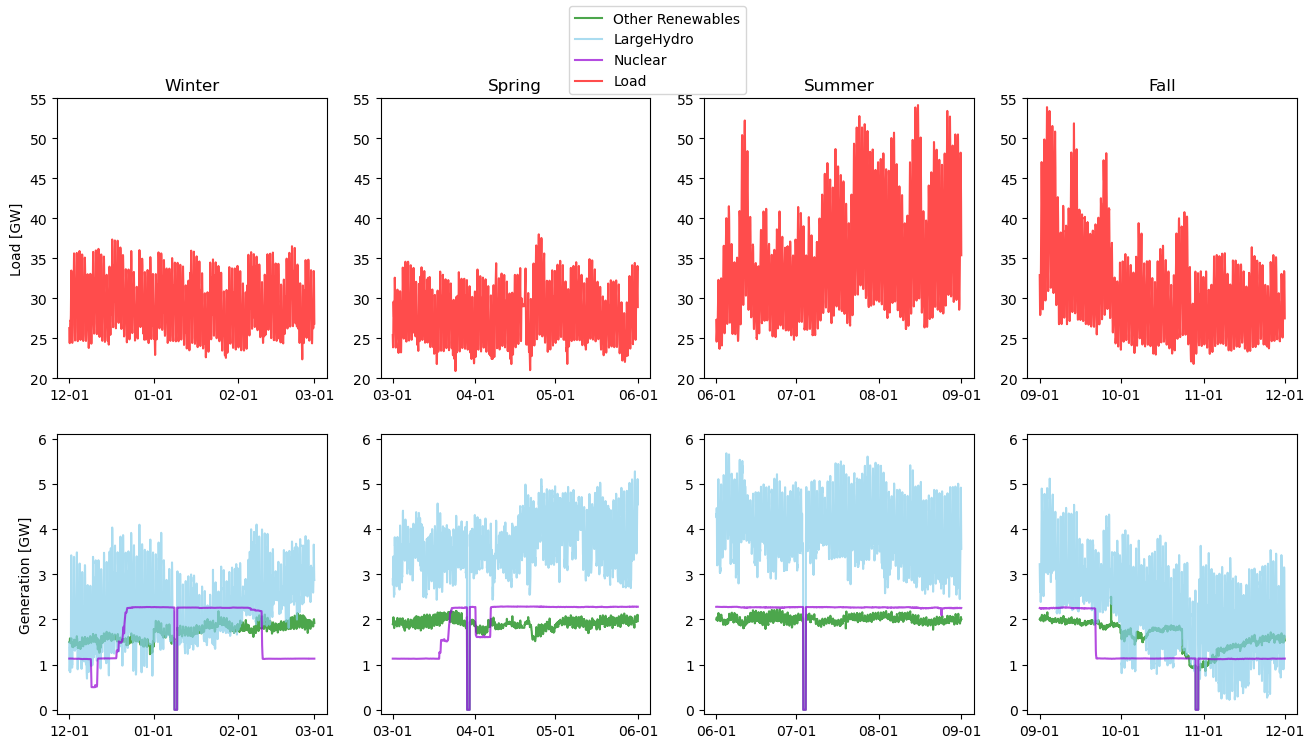

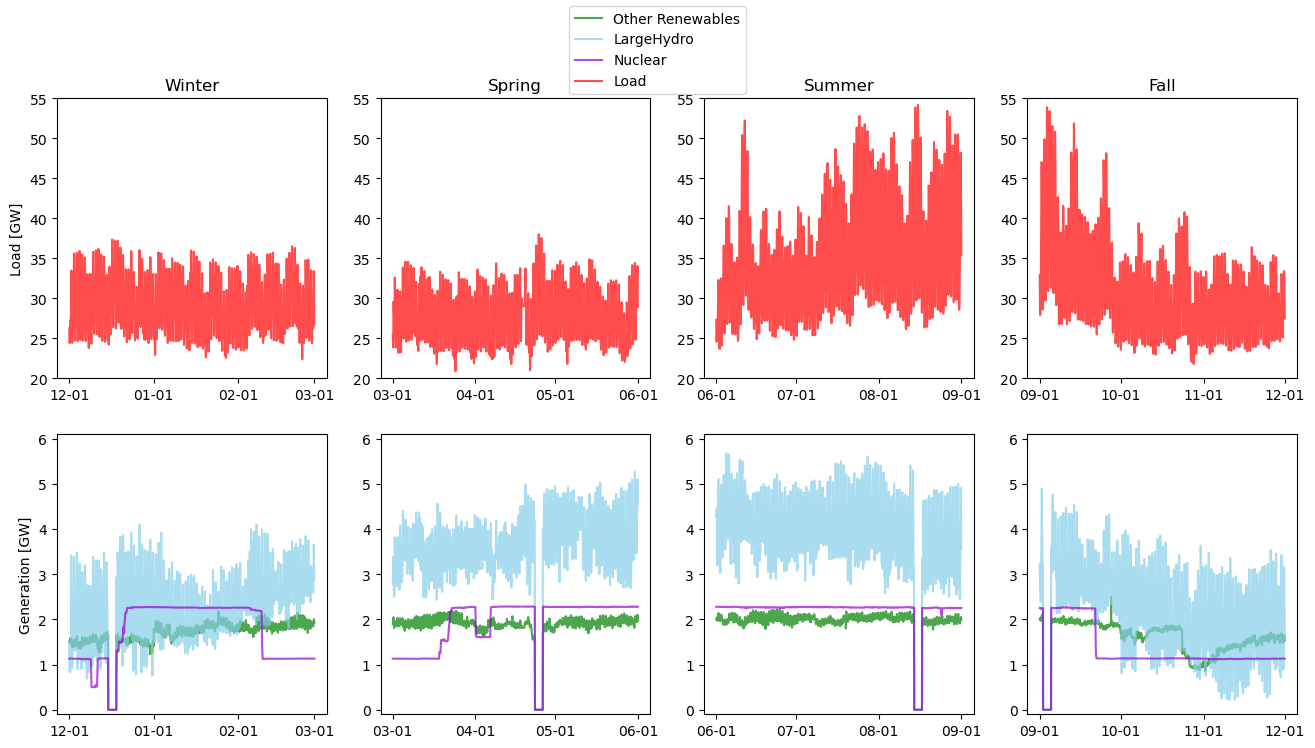

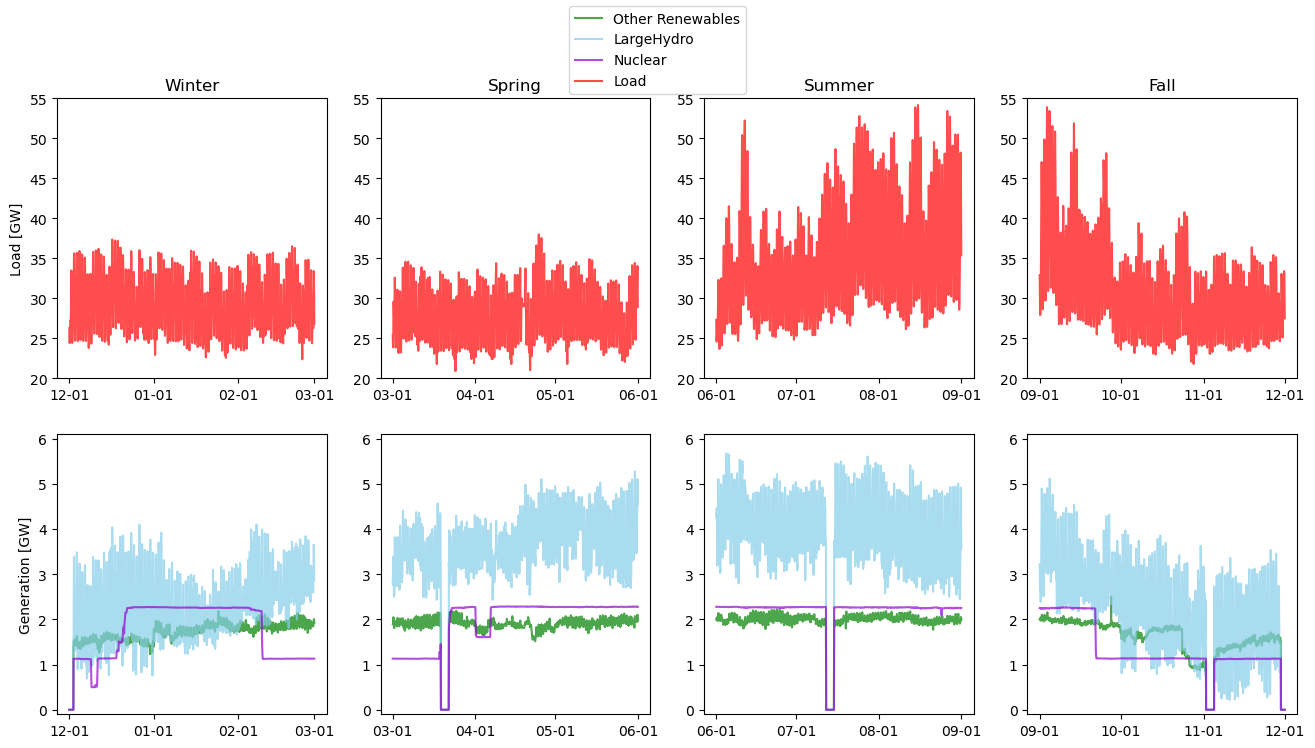

In [123]:
for scenario, data in save_data.items():
    plot_scenario(scenario_name=scenario, df=data)